### Exploratory Data Analysis
## For this analysis, you are provided with a large data set consisting of hotel reviews (text fields for positive and negative comments) and details about the stay (hotel location, time & length of stay, etc). Your target column of interest is Reviewer_Score that encodes positive sentiment as 1 and negative as 0.
### First, let's load the data and understand what we are working with.

Perform EDA on the data and mention 3-4 observations from which you can draw actionable insights. In your EDA, you may consider creating a data dictionary, basic statistical analysis, data visualizations, data cleaning and preprocessing to prepare the data for modeling.

### Preprocessing
Next, the text data needs to be processed for modelling.

Split the data into train and test sets and transform the positive and negative review columns using a CountVectorizer. Consider the following:
What tokenizer and text cleaning steps do you include?
Using the vectorizer, maximize the number of features at 500 and make sure that tokens used <10 times are dropped from the vocabulary.
This process may be done on the positive and negative review columns separately and then the resulting arrays merged with the original numeric features to form the final train and test data frames ready for modelling. In your column names, make sure you mark which words are coming from the positive vs negative reviews (you can use a prefix such as pos_ and neg_).

### Modelling
As the data is now ready for modelling, we will be creating two separate models with optimization and evaluation of each.

Fit a logistic regression model on the data and analyze the test and train accuracy. Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1). Similarly, find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0). What actionable insights can you draw from these?

Using a pipeline, combine PCA with a decision tree classifier.

Optimize at least 3 hyperparameters including the maximum tree depth and the minimum number of data points required on each leaf node.
You can use 20 principle components.
The best parameters should be found using 5-fold cross validation.
Contrast the best results here with the logistic regression model and provide any insights that you may draw from the results.

For your best performing model, conduct a more in-depth evaluation by analyzing the confusion matrix and commenting on the model errors and metrics such as precision and recall.
Requirements
Please submit your Jupyter notebook which should include commented code and extensive markdown cells explaining your process and insights. Make sure to add a table of contents, introduction, proper section headers and a conclusion section. Your communication in the markdown cells and the code cell outputs should allow anyone to understand your process and findings without the need to read the code.

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from warnings import filterwarnings
filterwarnings(action='ignore')

### FUNCTIONS

In [38]:

def has_special_chars(string):
    return not string.isalnum()

df = pd.DataFrame({'col1': ['Hello', 'World!', '123']})

df['has_special_chars'] = df['col1'].apply(has_special_chars)

print(df)

     col1  has_special_chars
0   Hello              False
1  World!               True
2     123              False


### DF check

In [39]:
hotel=pd.read_csv('data/Hotel_Reviews.csv')

In [40]:
# overview of objects

# 2 Objects are positive and negative review content 
# Target Variables
#### 
hotel.columns

Index(['Unnamed: 0', 'Additional_Number_of_Scoring', 'Average_Score',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'Days_Since_Review', 'Latitude', 'Longitude', 'Day', 'Month', 'Year',
       'Reviewer_Nationality_Australia', 'Reviewer_Nationality_Ireland',
       'Reviewer_Nationality_UAE', 'Reviewer_Nationality_UK',
       'Reviewer_Nationality_USA', 'Reviewer_Nationality_Other',
       'Hotel_Address_Amsterdam', 'Hotel_Address_Barcelona',
       'Hotel_Address_London', 'Hotel_Address_Milan', 'Hotel_Address_Paris',
       'Hotel_Address_Vienna', 'Leisure_Trip', 'Nights_Stayed'],
      dtype='object')

In [41]:
hotel.shape

(515738, 30)

In [42]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Unnamed: 0                                  515738 non-null  int64  
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Average_Score                               515738 non-null  float64
 3   Negative_Review                             515738 non-null  object 
 4   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 5   Total_Number_of_Reviews                     515738 non-null  int64  
 6   Positive_Review                             515738 non-null  object 
 7   Review_Total_Positive_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews_Reviewer_Has_Given  515738 non-null  int64  
 9   Reviewer_Score                              515738 non-null  int64  
 

In [43]:
#hotel.rename(columns={'Unnamed: 0' : 'old_index'}, inplace=True)

In [44]:
# 'Old-index' contains no new information, as expected. Dropping column
#
for rows in hotel['Unnamed: 0']:
    if hotel.index[rows] == hotel['Unnamed: 0'][rows]:
        continue
    else:
        print(rows)
print('done')

# drop columns
#
hotel.drop(columns=['Unnamed: 0'], inplace=True)

done


In [45]:
# Redo columns of df to make it more readable

hotel=hotel[['Reviewer_Score',
 'Nights_Stayed',
 'Positive_Review',
 'Negative_Review',
 'Additional_Number_of_Scoring',
 'Average_Score',
 'Leisure_Trip', 
 'Days_Since_Review',
 'Total_Number_of_Reviews', 
 'Total_Number_of_Reviews_Reviewer_Has_Given',
 'Review_Total_Negative_Word_Counts', 
 'Review_Total_Positive_Word_Counts',
 'Latitude',
 'Longitude',
 'Day',
 'Month',
 'Year',
 'Reviewer_Nationality_Australia',
 'Reviewer_Nationality_Ireland',
 'Reviewer_Nationality_UAE',
 'Reviewer_Nationality_UK',
 'Reviewer_Nationality_USA',
 'Reviewer_Nationality_Other',
 'Hotel_Address_Amsterdam',
 'Hotel_Address_Barcelona',
 'Hotel_Address_London', 
 'Hotel_Address_Milan', 
 'Hotel_Address_Paris',
 'Hotel_Address_Vienna']]


In [46]:
# No null values
hotel.isna().sum().sum()

0

In [47]:
# After removing old index, we can actually take a look a possible duplicates. The old index was a hindrance and it was shown
# in the earlier loop that it matches the index.

hotel.duplicated().value_counts()

False    515199
True        539
Name: count, dtype: int64

In [48]:
# Take a look at a duplicate line
hotel.loc[hotel.Year.eq(2015) & hotel.Day.eq(4) & hotel.Month.eq(8) & hotel.Reviewer_Nationality_UK.eq(1) & hotel.Total_Number_of_Reviews.eq(2515)]	

Reviewer_Score  Nights_Stayed  \
180112               1              1   
180458               1              1   

                                  Positive_Review  \
180112   Very convenient for Gare de Montparnasse   
180458   Very convenient for Gare de Montparnasse   

                           Negative_Review  Additional_Number_of_Scoring  \
180112   Need better directions from Metro                           228   
180458   Need better directions from Metro                           228   

        Average_Score  Leisure_Trip  Days_Since_Review  \
180112            7.9             1                730   
180458            7.9             1                730   

        Total_Number_of_Reviews  Total_Number_of_Reviews_Reviewer_Has_Given  \
180112                     2515                                           9   
180458                     2515                                           9   

        ...  Reviewer_Nationality_UAE  Reviewer_Nationality_UK  \
180112  ...                         0                        1   
180458  ...                         0                        1   

        Reviewer_Nationality_USA  Reviewer_Nationality_Other  \
180112                         0                           0   
180458                         0                           0   

        Hotel_Address_Amsterdam  Hotel_Address_Barcelona  \
180112                        0                        0   
180458                        0                        0   

        Hotel_Address_London  Hotel_Address_Milan  Hotel_Address_Paris  \
180112                     0                    0                    1   
180458                     0                    0                    1   

        Hotel_Address_Vienna  
180112                     0  
180458                     0  

[2 rows x 29 columns]

In [49]:
# Drop the duplicates, keep one copy. Index irrelevant presently, dropping first.

print(hotel.drop_duplicates(keep='first').shape)
hotel.drop_duplicates(keep='first',inplace=True)
print(hotel.shape)

(515199, 29)
(515199, 29)


In [50]:
# Checking duplicates after drop again

hotel.duplicated().value_counts()

False    515199
Name: count, dtype: int64

In [51]:
hotel.head(2)

Reviewer_Score  Nights_Stayed  \
0               0              6   
1               0              4   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   

                                     Negative_Review  \
0   I am so angry that i made this post available...   
1                                        No Negative   

   Additional_Number_of_Scoring  Average_Score  Leisure_Trip  \
0                           194            7.7             1   
1                           194            7.7             1   

   Days_Since_Review  Total_Number_of_Reviews  \
0                  0                     1403   
1                  0                     1403   

   Total_Number_of_Reviews_Reviewer_Has_Given  ...  Reviewer_Nationality_UAE  \
0                                           7  ...                         0   
1                                           7  ...                         0   

   Reviewer_Nationality_UK  Reviewer_Nationality_USA  \
0                        0                         0   
1                        0                         0   

   Reviewer_Nationality_Other  Hotel_Address_Amsterdam  \
0                           1                        1   
1                           0                        1   

   Hotel_Address_Barcelona  Hotel_Address_London  Hotel_Address_Milan  \
0                        0                     0                    0   
1                        0                     0                    0   

   Hotel_Address_Paris  Hotel_Address_Vienna  
0                    0                     0  
1                    0                     0  

[2 rows x 29 columns]

In [52]:
## Checking for special characters
print(hotel.Positive_Review.str.isalnum().value_counts())
print(hotel.Negative_Review.str.isalnum().value_counts())

Positive_Review
False    515186
True         13
Name: count, dtype: int64
Negative_Review
False    515193
True          6
Name: count, dtype: int64


In [53]:
hotel.loc[1].Negative_Review

'No Negative'

In [54]:
# Taking a look at special characters in review columns - may have to revisit this after talking to faculty.

#hotel[hotel.Negative_Review.str.isalnum()==True]

In [55]:
hotel.Positive_Review.str.isalnum().value_counts()

Positive_Review
False    515186
True         13
Name: count, dtype: int64

#### Data Dictionary

In [56]:
# Create a sample DataFrame
data = {
    'type': []
}
df = pd.DataFrame(data)
data_dictionary = pd.DataFrame(index=df.columns, columns=hotel.columns)
# Create a data dictionary


In [57]:
data_dictionary

Reviewer_Score Nights_Stayed Positive_Review Negative_Review  \
type            NaN           NaN             NaN             NaN   

     Additional_Number_of_Scoring Average_Score Leisure_Trip  \
type                          NaN           NaN          NaN   

     Days_Since_Review Total_Number_of_Reviews  \
type               NaN                     NaN   

     Total_Number_of_Reviews_Reviewer_Has_Given  ... Reviewer_Nationality_UAE  \
type                                        NaN  ...                      NaN   

     Reviewer_Nationality_UK Reviewer_Nationality_USA  \
type                     NaN                      NaN   

     Reviewer_Nationality_Other Hotel_Address_Amsterdam  \
type                        NaN                     NaN   

     Hotel_Address_Barcelona Hotel_Address_London Hotel_Address_Milan  \
type                     NaN                  NaN                 NaN   

     Hotel_Address_Paris Hotel_Address_Vienna  
type                 NaN                  NaN  

[1 rows x 29 columns]

In [58]:
hotel.head(1)

Reviewer_Score  Nights_Stayed  \
0               0              6   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   

                                     Negative_Review  \
0   I am so angry that i made this post available...   

   Additional_Number_of_Scoring  Average_Score  Leisure_Trip  \
0                           194            7.7             1   

   Days_Since_Review  Total_Number_of_Reviews  \
0                  0                     1403   

   Total_Number_of_Reviews_Reviewer_Has_Given  ...  Reviewer_Nationality_UAE  \
0                                           7  ...                         0   

   Reviewer_Nationality_UK  Reviewer_Nationality_USA  \
0                        0                         0   

   Reviewer_Nationality_Other  Hotel_Address_Amsterdam  \
0                           1                        1   

   Hotel_Address_Barcelona  Hotel_Address_London  Hotel_Address_Milan  \
0                        0                     0                    0   

   Hotel_Address_Paris  Hotel_Address_Vienna  
0                    0                     0  

[1 rows x 29 columns]

In [59]:
data_dictionary

Reviewer_Score Nights_Stayed Positive_Review Negative_Review  \
type            NaN           NaN             NaN             NaN   

     Additional_Number_of_Scoring Average_Score Leisure_Trip  \
type                          NaN           NaN          NaN   

     Days_Since_Review Total_Number_of_Reviews  \
type               NaN                     NaN   

     Total_Number_of_Reviews_Reviewer_Has_Given  ... Reviewer_Nationality_UAE  \
type                                        NaN  ...                      NaN   

     Reviewer_Nationality_UK Reviewer_Nationality_USA  \
type                     NaN                      NaN   

     Reviewer_Nationality_Other Hotel_Address_Amsterdam  \
type                        NaN                     NaN   

     Hotel_Address_Barcelona Hotel_Address_London Hotel_Address_Milan  \
type                     NaN                  NaN                 NaN   

     Hotel_Address_Paris Hotel_Address_Vienna  
type                 NaN                  NaN  

[1 rows x 29 columns]

In [60]:
is_na=[]
dtype=[]
duplicated=[]

# Establishing columns as needed
for col in hotel.columns:
    data_dictionary[col].type=hotel[col].dtype
    print(hotel[col].dtype)

int64
int64
object
object
int64
float64
int64
int64
int64
int64
int64
int64
float64
float64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64


In [61]:
hotel['Average_Score'].isna().value_counts()

Average_Score
False    515199
Name: count, dtype: int64

In [62]:
data_dictionary=data_dictionary.T

In [63]:
data_dictionary

type
Reviewer_Score                                int64
Nights_Stayed                                 int64
Positive_Review                              object
Negative_Review                              object
Additional_Number_of_Scoring                  int64
Average_Score                               float64
Leisure_Trip                                  int64
Days_Since_Review                             int64
Total_Number_of_Reviews                       int64
Total_Number_of_Reviews_Reviewer_Has_Given    int64
Review_Total_Negative_Word_Counts             int64
Review_Total_Positive_Word_Counts             int64
Latitude                                    float64
Longitude                                   float64
Day                                           int64
Month                                         int64
Year                                          int64
Reviewer_Nationality_Australia                int64
Reviewer_Nationality_Ireland                  int64
Reviewer_Nationality_UAE                      int64
Reviewer_Nationality_UK                       int64
Reviewer_Nationality_USA                      int64
Reviewer_Nationality_Other                    int64
Hotel_Address_Amsterdam                       int64
Hotel_Address_Barcelona                       int64
Hotel_Address_London                          int64
Hotel_Address_Milan                           int64
Hotel_Address_Paris                           int64
Hotel_Address_Vienna                          int64

In [64]:
data_dictionary

type
Reviewer_Score                                int64
Nights_Stayed                                 int64
Positive_Review                              object
Negative_Review                              object
Additional_Number_of_Scoring                  int64
Average_Score                               float64
Leisure_Trip                                  int64
Days_Since_Review                             int64
Total_Number_of_Reviews                       int64
Total_Number_of_Reviews_Reviewer_Has_Given    int64
Review_Total_Negative_Word_Counts             int64
Review_Total_Positive_Word_Counts             int64
Latitude                                    float64
Longitude                                   float64
Day                                           int64
Month                                         int64
Year                                          int64
Reviewer_Nationality_Australia                int64
Reviewer_Nationality_Ireland                  int64
Reviewer_Nationality_UAE                      int64
Reviewer_Nationality_UK                       int64
Reviewer_Nationality_USA                      int64
Reviewer_Nationality_Other                    int64
Hotel_Address_Amsterdam                       int64
Hotel_Address_Barcelona                       int64
Hotel_Address_London                          int64
Hotel_Address_Milan                           int64
Hotel_Address_Paris                           int64
Hotel_Address_Vienna                          int64

In [65]:
# data_dictionary=data_dictionary.T

In [66]:
hotel.head(1)

Reviewer_Score  Nights_Stayed  \
0               0              6   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   

                                     Negative_Review  \
0   I am so angry that i made this post available...   

   Additional_Number_of_Scoring  Average_Score  Leisure_Trip  \
0                           194            7.7             1   

   Days_Since_Review  Total_Number_of_Reviews  \
0                  0                     1403   

   Total_Number_of_Reviews_Reviewer_Has_Given  ...  Reviewer_Nationality_UAE  \
0                                           7  ...                         0   

   Reviewer_Nationality_UK  Reviewer_Nationality_USA  \
0                        0                         0   

   Reviewer_Nationality_Other  Hotel_Address_Amsterdam  \
0                           1                        1   

   Hotel_Address_Barcelona  Hotel_Address_London  Hotel_Address_Milan  \
0                        0                     0                    0   

   Hotel_Address_Paris  Hotel_Address_Vienna  
0                    0                     0  

[1 rows x 29 columns]

In [67]:
print('nullls: ',hotel.isna().sum().sum())
print('\nDuplicated: \n',hotel.duplicated().value_counts())

nullls:  0

Duplicated: 
 False    515199
Name: count, dtype: int64


### EDA

In [32]:
hotel.head(3)

Reviewer_Score  Nights_Stayed  \
0               0              6   
1               0              4   
2               0              3   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   

                                     Negative_Review  \
0   I am so angry that i made this post available...   
1                                        No Negative   
2   Rooms are nice but for elderly a bit difficul...   

   Additional_Number_of_Scoring  Average_Score  Leisure_Trip  \
0                           194            7.7             1   
1                           194            7.7             1   
2                           194            7.7             1   

   Days_Since_Review  Total_Number_of_Reviews  \
0                  0                     1403   
1                  0                     1403   
2                  3                     1403   

   Total_Number_of_Reviews_Reviewer_Has_Given  ...  Reviewer_Nationality_UAE  \
0                                           7  ...                         0   
1                                           7  ...                         0   
2                                           9  ...                         0   

   Reviewer_Nationality_UK  Reviewer_Nationality_USA  \
0                        0                         0   
1                        0                         0   
2                        0                         0   

   Reviewer_Nationality_Other  Hotel_Address_Amsterdam  \
0                           1                        1   
1                           0                        1   
2                           0                        1   

   Hotel_Address_Barcelona  Hotel_Address_London  Hotel_Address_Milan  \
0                        0                     0                    0   
1                        0                     0                    0   
2                        0                     0                    0   

   Hotel_Address_Paris  Hotel_Address_Vienna  
0                    0                     0  
1                    0                     0  
2                    0                     0  

[3 rows x 29 columns]

In [69]:
# Convert dates into continuous date column for plotting purposes

hotel['Review_Date'] = pd.to_datetime(hotel[['Year', 'Month', 'Day']])
hotel.Review_Date

0        2017-08-03
1        2017-08-03
2        2017-07-31
3        2017-07-31
4        2017-07-24
            ...    
515733   2015-08-30
515734   2015-08-22
515735   2015-08-19
515736   2015-08-17
515737   2015-08-09
Name: Review_Date, Length: 515199, dtype: datetime64[ns]

<Axes: xlabel='Review_Date'>

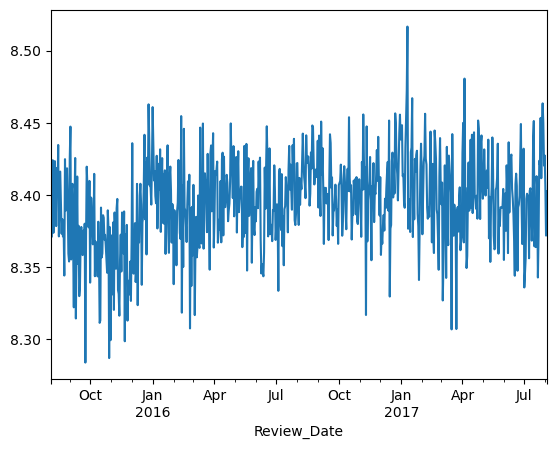

In [70]:
averages=pd.DataFrame
averages=hotel.groupby('Review_Date').Average_Score.mean()

averages.shape
hotel.groupby('Review_Date')['Average_Score'].mean().plot()

<Axes: xlabel='Review_Date', ylabel='Average_Score'>

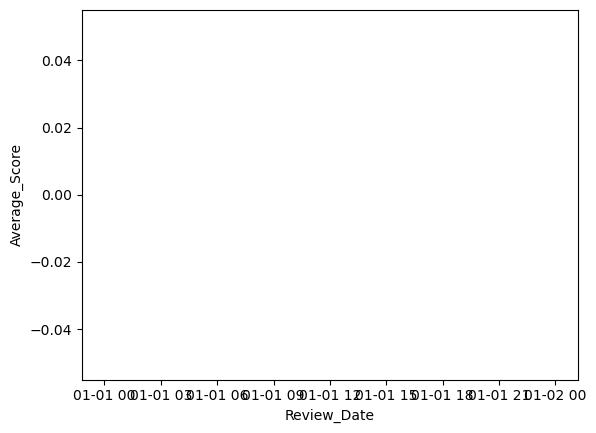

In [71]:
sns.lineplot(x=hotel.Review_Date,y=hotel.groupby('Review_Date')['Average_Score'].mean())

In [74]:

#sns.lineplot(x=hotel['Review_Date'], y=hotel())

In [75]:
AverageReviews=hotel.groupby('Review_Date').Average_Score.rolling(window=5).mean().to_frame().reset_index()

In [76]:
AverageReviews['Average_Score_std']=hotel.groupby('Review_Date').Average_Score.mean()

In [77]:
AverageReviews['monthYear']=AverageReviews.Review_Date.dt.month.astype('str')+'-'+AverageReviews.Review_Date.dt.year.astype('str')

### EDA

### 

In [87]:
hotel.shape

(515199, 30)

In [ ]:
plt.figure()
sns.pairplot(hotel)

In [ ]:
len(pd.concat([hotel.Additional_Number_of_Scoring,hotel.Total_Number_of_Reviews]).unique())

In [88]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515199 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Reviewer_Score                              515199 non-null  int64         
 1   Nights_Stayed                               515199 non-null  int64         
 2   Positive_Review                             515199 non-null  object        
 3   Negative_Review                             515199 non-null  object        
 4   Additional_Number_of_Scoring                515199 non-null  int64         
 5   Average_Score                               515199 non-null  float64       
 6   Leisure_Trip                                515199 non-null  int64         
 7   Days_Since_Review                           515199 non-null  int64         
 8   Total_Number_of_Reviews                     515199 non-null  int64         
 9 

In [91]:
hotel.columns[0:17]

Index(['Reviewer_Score', 'Nights_Stayed', 'Positive_Review', 'Negative_Review',
       'Additional_Number_of_Scoring', 'Average_Score', 'Leisure_Trip',
       'Days_Since_Review', 'Total_Number_of_Reviews',
       'Total_Number_of_Reviews_Reviewer_Has_Given',
       'Review_Total_Negative_Word_Counts',
       'Review_Total_Positive_Word_Counts', 'Latitude', 'Longitude', 'Day',
       'Month', 'Year'],
      dtype='object')

In [93]:
#hotel no location dummies
hotel_nd=hotel[hotel.columns[0:17]]

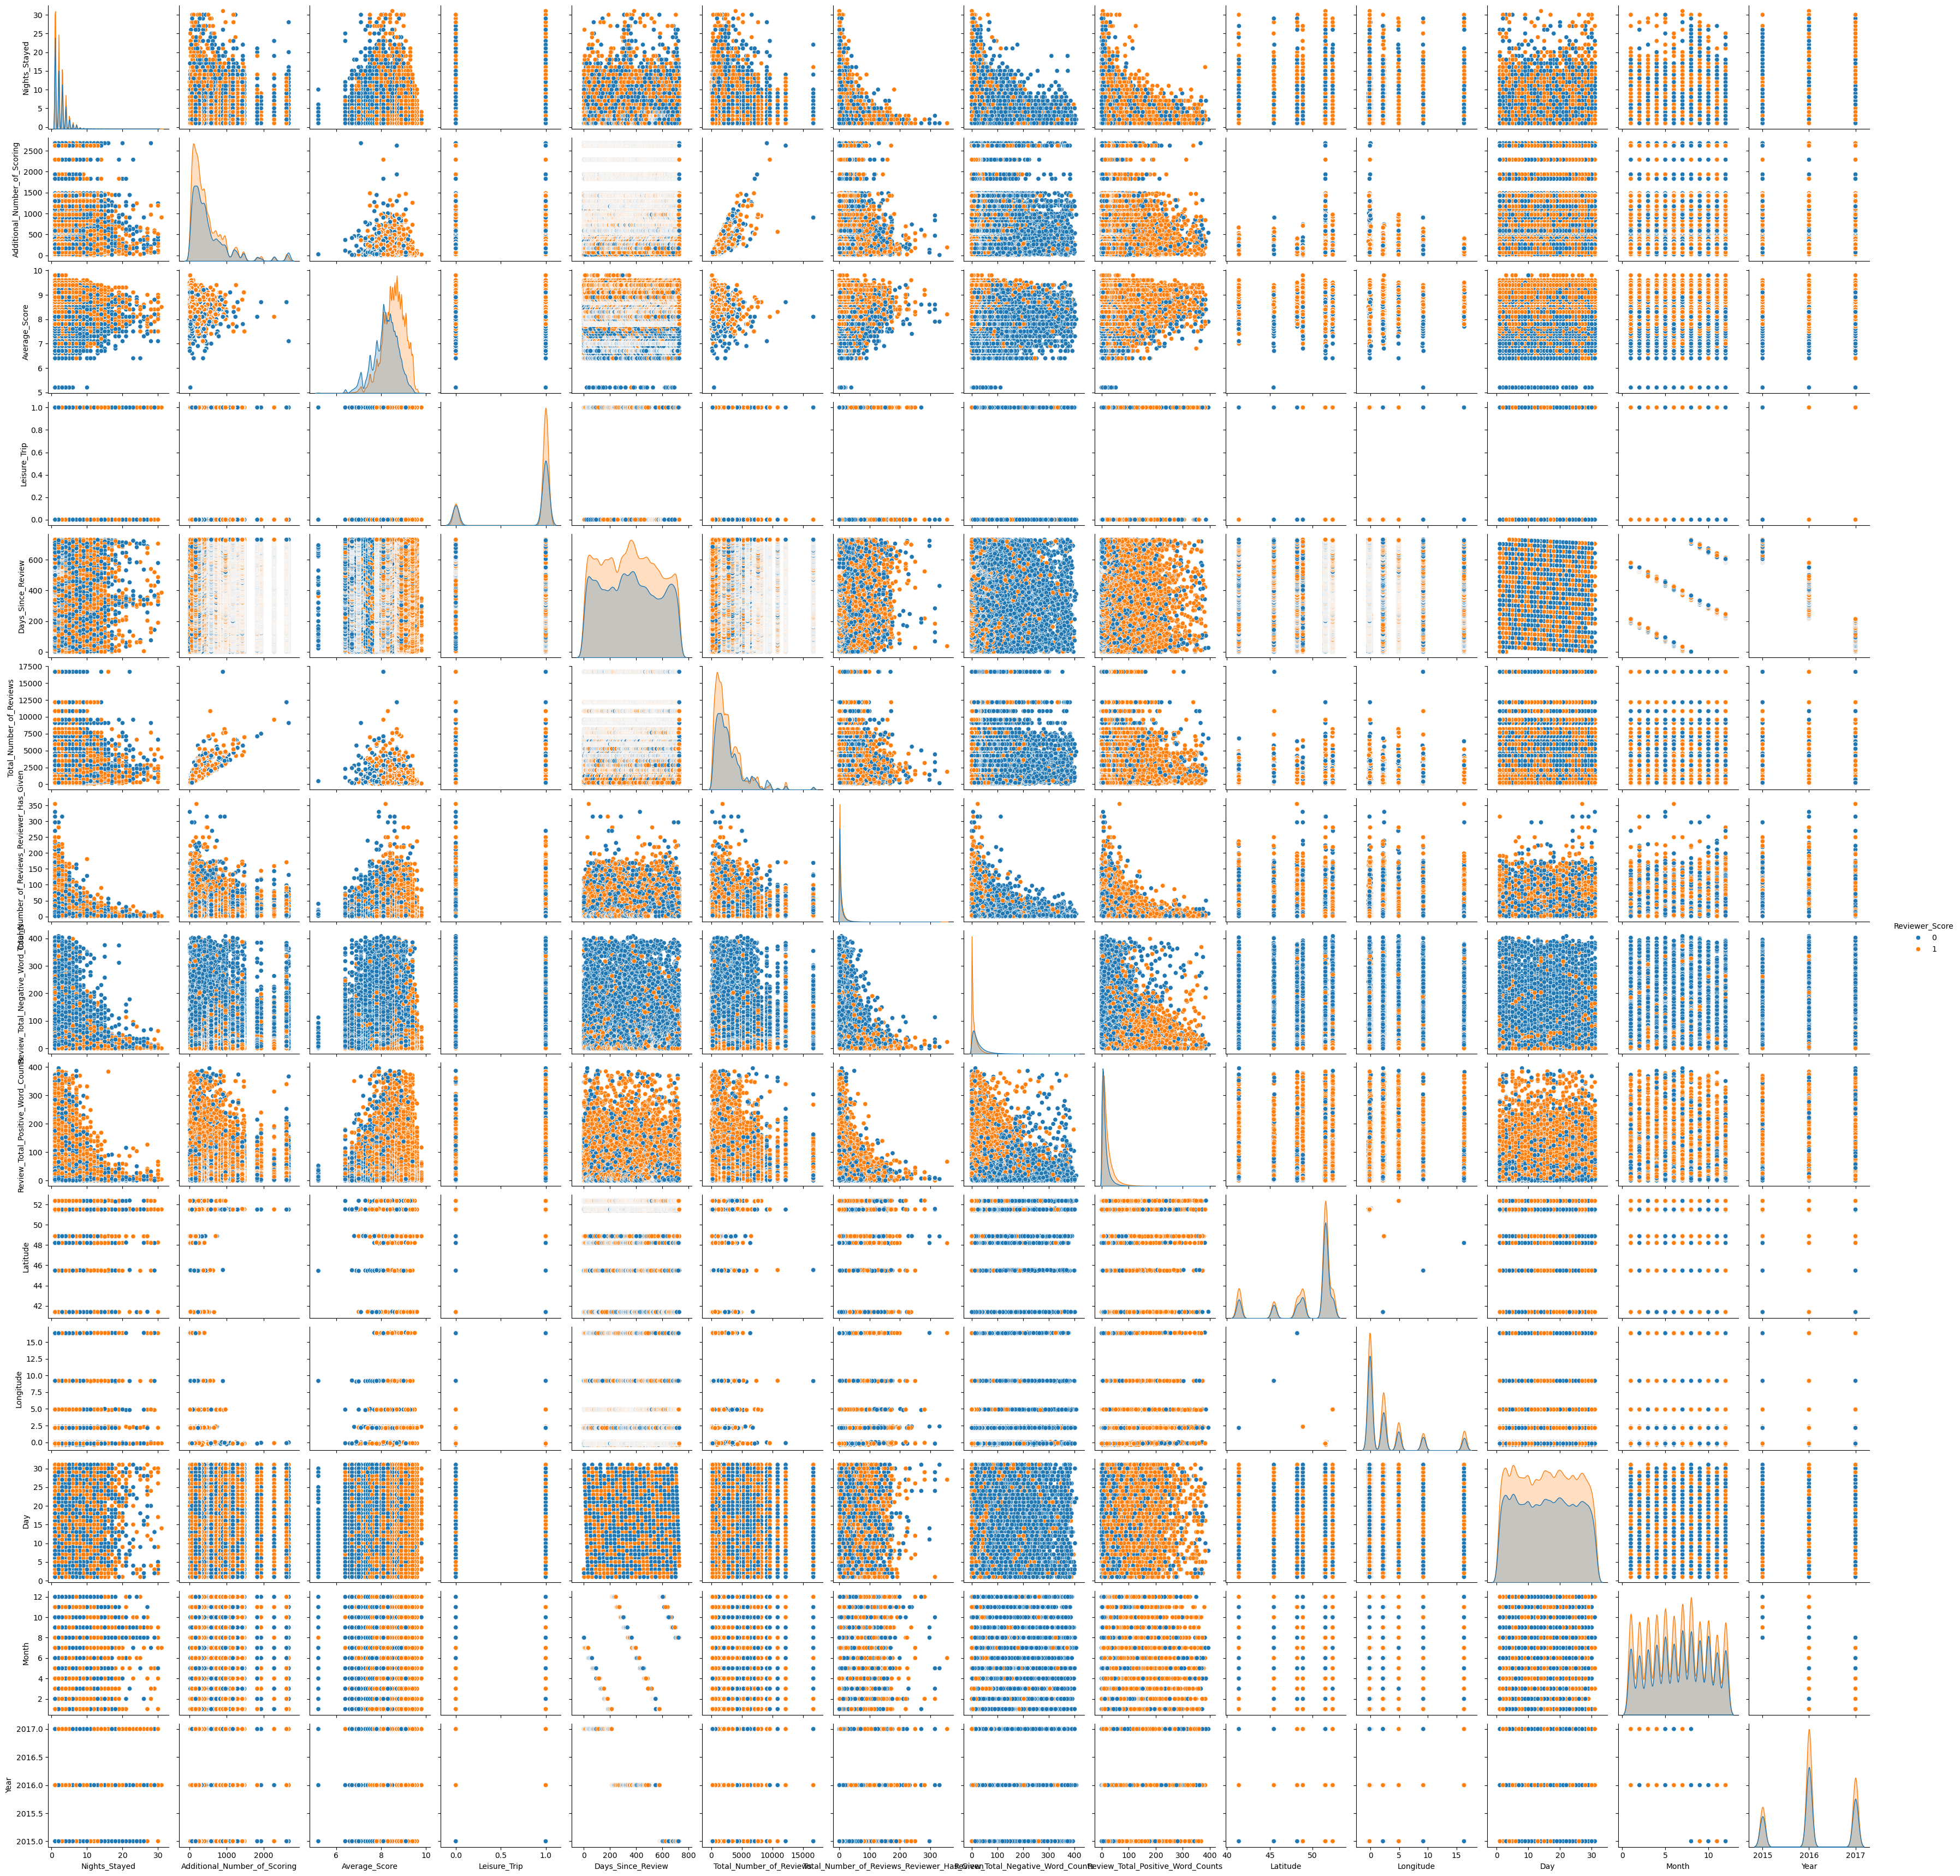

In [96]:
sns.pairplot(hotel_nd,hue='Reviewer_Score')

With this wildly unnecessary pair-plot, I can get a sense of where some obvious relationships can be found.
Some items of interest:
- There seems to be a differential between control groups(number of review a reviewer has given ~ Average Score)
- 


In [103]:
#need another table to drop reviews
hotel_nd_nreviews=hotel_nd

In [104]:
hotel_nd_nreviews.head(1)

Reviewer_Score  Nights_Stayed  \
0               0              6   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   

                                     Negative_Review  \
0   I am so angry that i made this post available...   

   Additional_Number_of_Scoring  Average_Score  Leisure_Trip  \
0                           194            7.7             1   

   Days_Since_Review  Total_Number_of_Reviews  \
0                  0                     1403   

   Total_Number_of_Reviews_Reviewer_Has_Given  \
0                                           7   

   Review_Total_Negative_Word_Counts  Review_Total_Positive_Word_Counts  \
0                                397                                 11   

    Latitude  Longitude  Day  Month  Year  
0  52.360576   4.915968    3      8  2017

In [105]:
hotel_nd_nreviews=hotel_nd.copy()

In [108]:
hotel_nd_nreviews.drop(columns=(['Positive_Review','Negative_Review']),inplace=True)

In [110]:
hotel_nd_nreviews.head(1)

Reviewer_Score  Nights_Stayed  Additional_Number_of_Scoring  Average_Score  \
0               0              6                           194            7.7   

   Leisure_Trip  Days_Since_Review  Total_Number_of_Reviews  \
0             1                  0                     1403   

   Total_Number_of_Reviews_Reviewer_Has_Given  \
0                                           7   

   Review_Total_Negative_Word_Counts  Review_Total_Positive_Word_Counts  \
0                                397                                 11   

    Latitude  Longitude  Day  Month  Year  
0  52.360576   4.915968    3      8  2017

<function matplotlib.pyplot.show(close=None, block=None)>

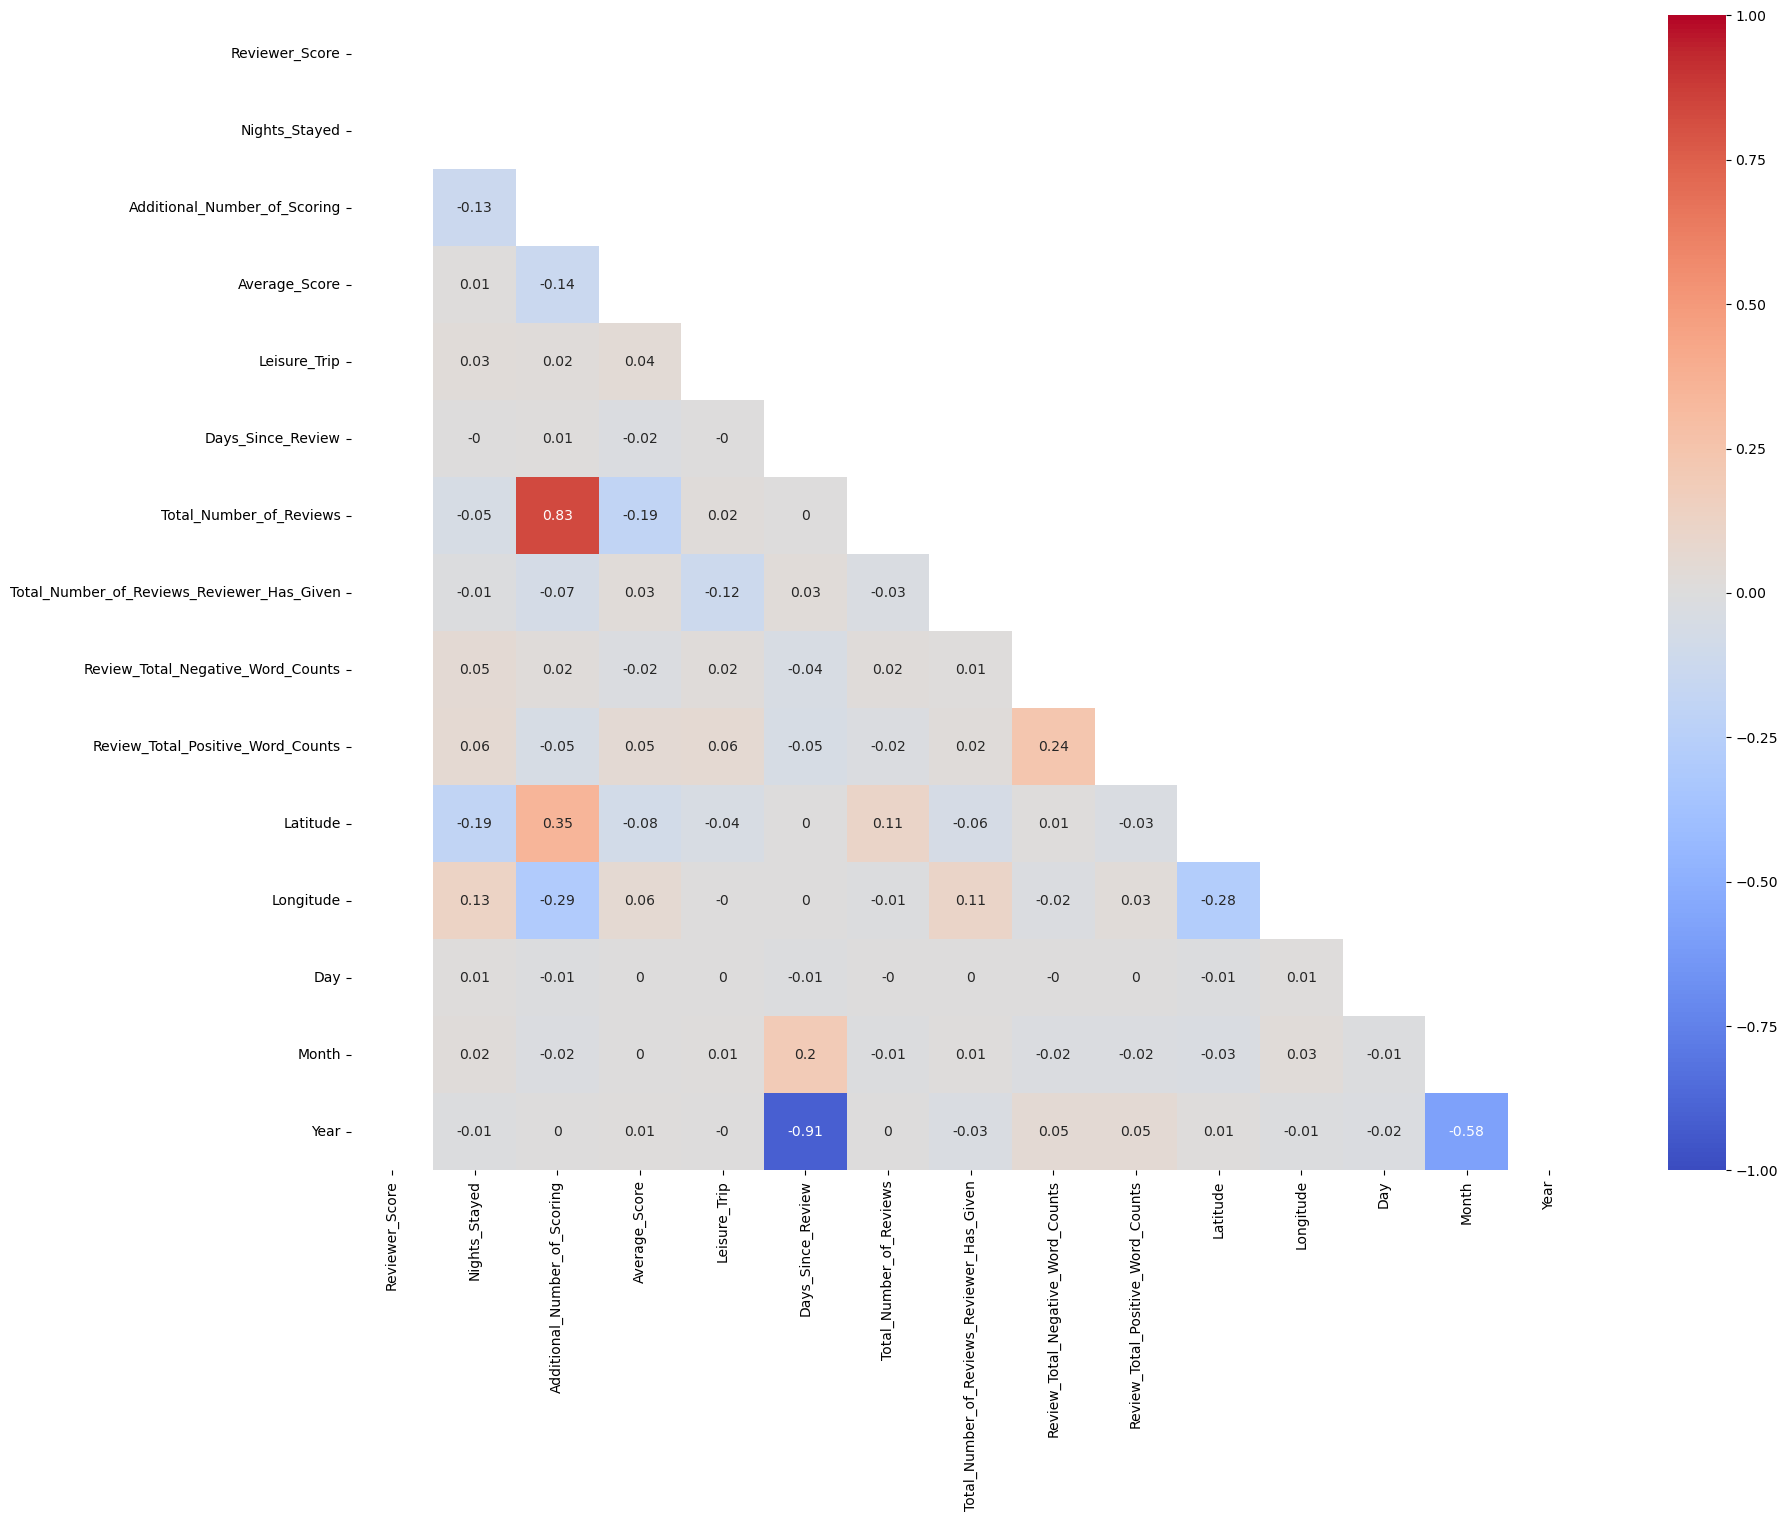

In [115]:
# Correlations for independent variables
indcorr=hotel_nd_nreviews[hotel_nd_nreviews.Reviewer_Score==1].corr()
#Heatmap
mask=np.triu(indcorr)
plt.figure(figsize=(20,15))
sns.heatmap(indcorr.round(2), vmax=1,vmin=-1,center=0,cmap='coolwarm',mask=mask, annot=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

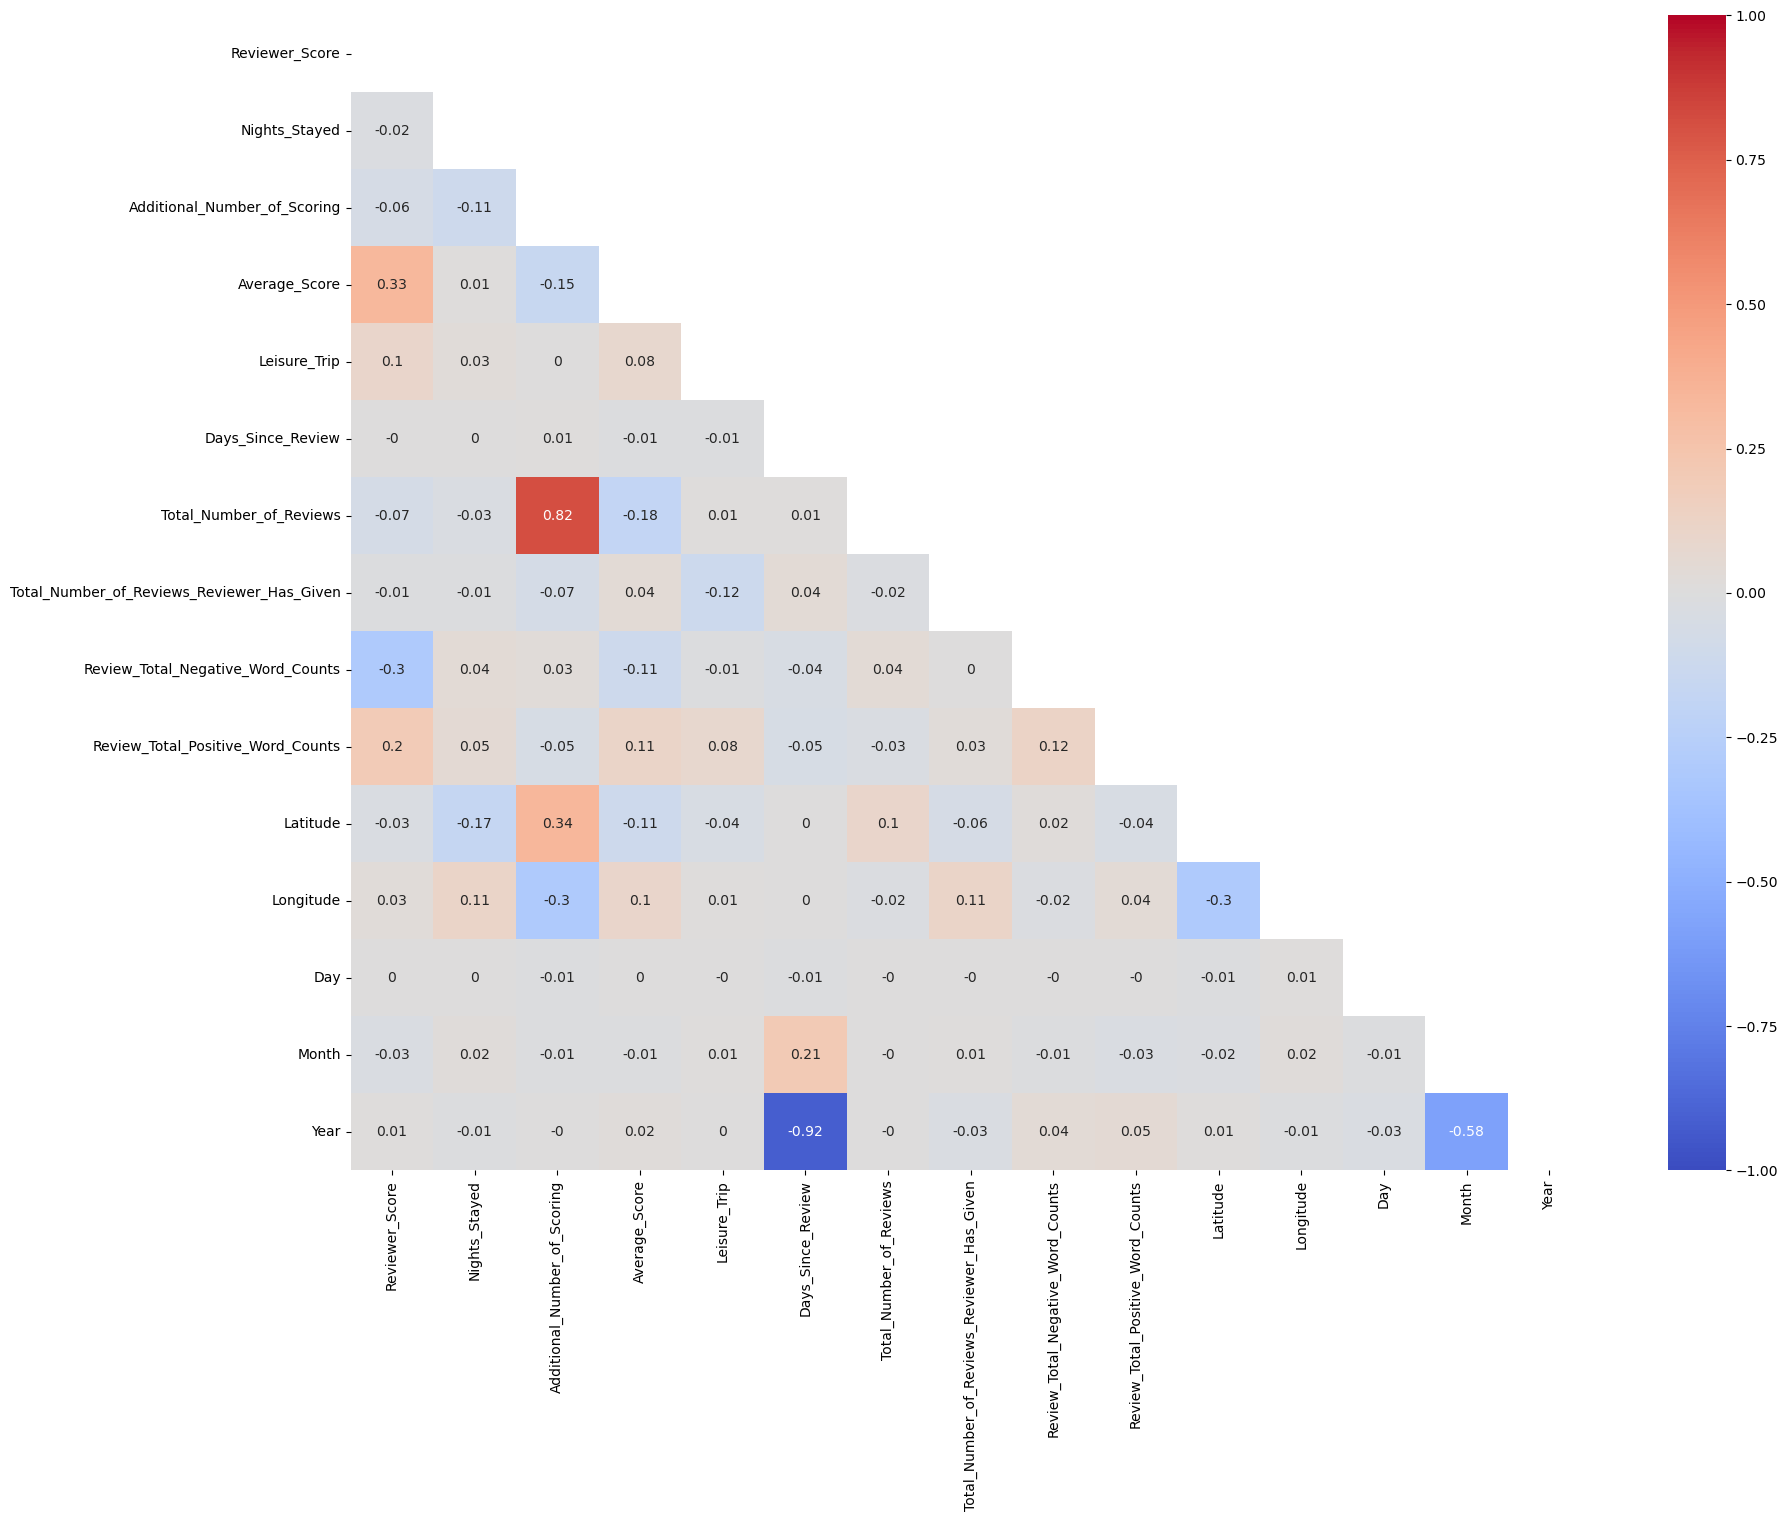

In [114]:
# Correlations for independent variables
indcorr=hotel_nd_nreviews[hotel_nd_nreviews.Reviewer_Score==1].corr()
#Heatmap
mask=np.triu(indcorr)
plt.figure(figsize=(20,15))
sns.heatmap(indcorr.round(2), vmax=1,vmin=-1,center=0,cmap='coolwarm',mask=mask, annot=True)
plt.show

In [122]:
inverse_hotel_nd_nreviews=hotel_nd_nreviews[hotel_nd_nreviews.Reviewer_Score==0]
#inverse_hotel_nd_nreviews.Reviewer_Score=1

In [127]:
hotel_nd_nreviews[hotel_nd_nreviews.Reviewer_Score==1].count()

Reviewer_Score                                293715
Nights_Stayed                                 293715
Additional_Number_of_Scoring                  293715
Average_Score                                 293715
Leisure_Trip                                  293715
Days_Since_Review                             293715
Total_Number_of_Reviews                       293715
Total_Number_of_Reviews_Reviewer_Has_Given    293715
Review_Total_Negative_Word_Counts             293715
Review_Total_Positive_Word_Counts             293715
Latitude                                      293715
Longitude                                     293715
Day                                           293715
Month                                         293715
Year                                          293715
dtype: int64

In [123]:
inverse_hotel_nd_nreviews.head(3)

Reviewer_Score  Nights_Stayed  Additional_Number_of_Scoring  Average_Score  \
0               1              6                           194            7.7   
1               1              4                           194            7.7   
2               1              3                           194            7.7   

   Leisure_Trip  Days_Since_Review  Total_Number_of_Reviews  \
0             1                  0                     1403   
1             1                  0                     1403   
2             1                  3                     1403   

   Total_Number_of_Reviews_Reviewer_Has_Given  \
0                                           7   
1                                           7   
2                                           9   

   Review_Total_Negative_Word_Counts  Review_Total_Positive_Word_Counts  \
0                                397                                 11   
1                                  0                                105   
2                                 42                                 21   

    Latitude  Longitude  Day  Month  Year  
0  52.360576   4.915968    3      8  2017  
1  52.360576   4.915968    3      8  2017  
2  52.360576   4.915968   31      7  2017

<function matplotlib.pyplot.show(close=None, block=None)>

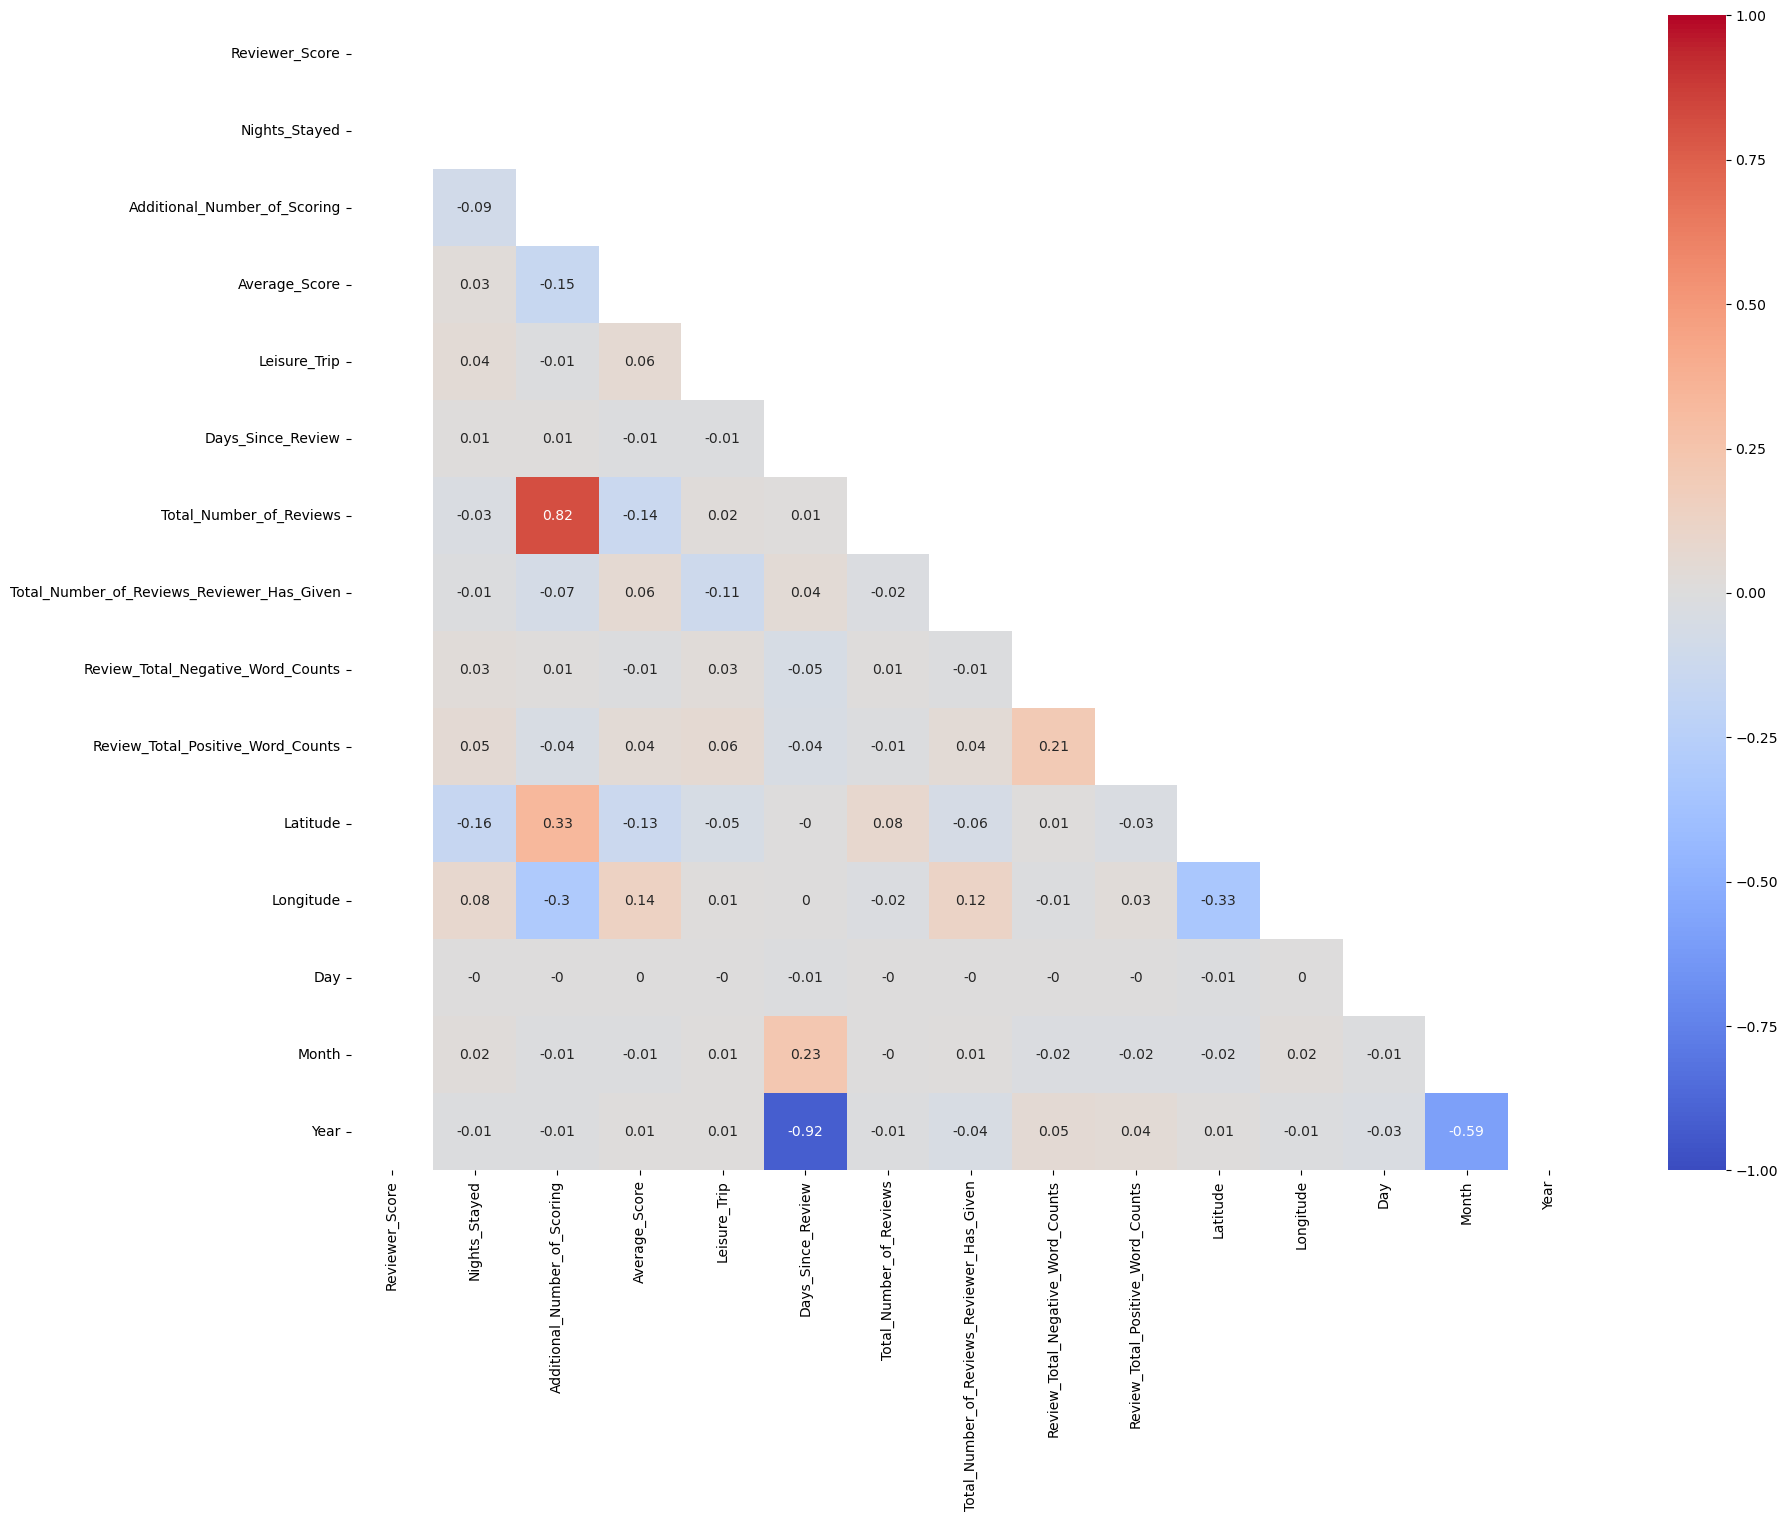

In [128]:
# Correlations for independent variables
indcorr=inverse_hotel_nd_nreviews.corr()
#Heatmap
mask=np.triu(indcorr)
plt.figure(figsize=(20,15))
sns.heatmap(indcorr.round(2), vmax=1,vmin=-1,center=0,cmap='coolwarm',mask=mask, annot=True)
plt.show

**Correlation Heatmaps**

It's interesting to see. When the data is evaluated as an independent set, there is some correlation among variables.
It's intuitive that a positive reviewer score is correlated to higher average scores, you don't see the inverse relationship with negative reviewer scores. 
Some notes:
- Most significant features:
    - Days Since Reviews ~ Year
    - Total # Reviews ~ Additional Number of Scoring


In [ ]:
#### Looking at PCA
### Target 

In [ ]:
hotel.Total_Number_of_Reviews_Reviewer_Has_Given.describe()	

In [ ]:
hotel[hotel.Reviewer_Score==1].Average_Score.describe()

In [ ]:
plt.figure()
hotel[hotel.Reviewer_Score==1].Average_Score.hist()
plt.axvline(x=hotel[hotel.Reviewer_Score==1].mean())

<Axes: xlabel='Average_Score', ylabel='Count'>

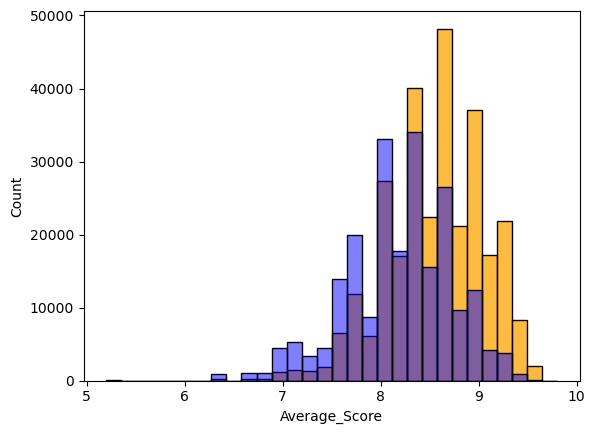

In [153]:
sns.histplot(hotel[hotel.Reviewer_Score==1].Average_Score, bins=30,color='orange')
sns.histplot(hotel[hotel.Reviewer_Score==0].Average_Score,bins=30, alpha=0.5,color='blue')

Text(0.5, 1.0, 'Mirror Distribution of Negative and Positive Word Counts')

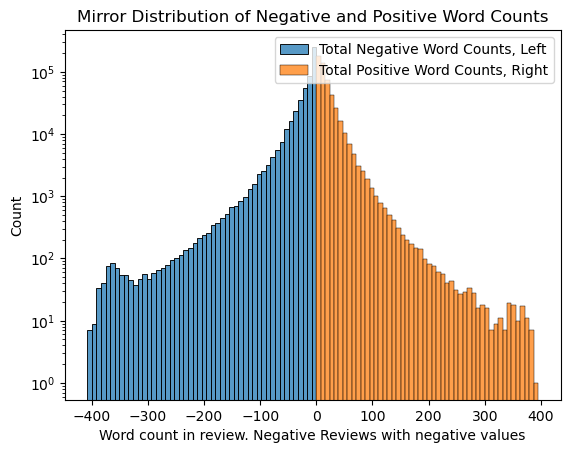

In [148]:
sns.histplot(-hotel.Review_Total_Negative_Word_Counts, label='Total Negative Word Counts, Left', bins=50)
sns.histplot(hotel.Review_Total_Positive_Word_Counts,label='Total Positive Word Counts, Right',bins=50)
plt.yscale('log')
plt.xlabel('Word count in review. Negative Reviews with negative values')
plt.legend()
plt.title('Mirror Distribution of Negative and Positive Word Counts')

In [ ]:
#Perhaps unnecessary but I thuoght it might be a good way to visualize any difference
#Between the two. Except 

<Axes: >

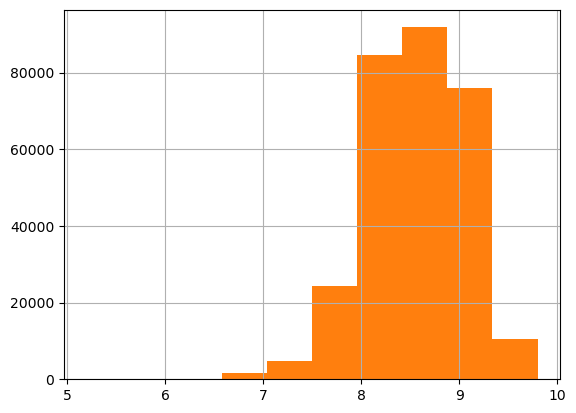

In [81]:
hotel[hotel.Reviewer_Score==1].Average_Score.hist()
sns.histplot(hotel[hotel.Reviewer_Score==1].Average_Score.hist()

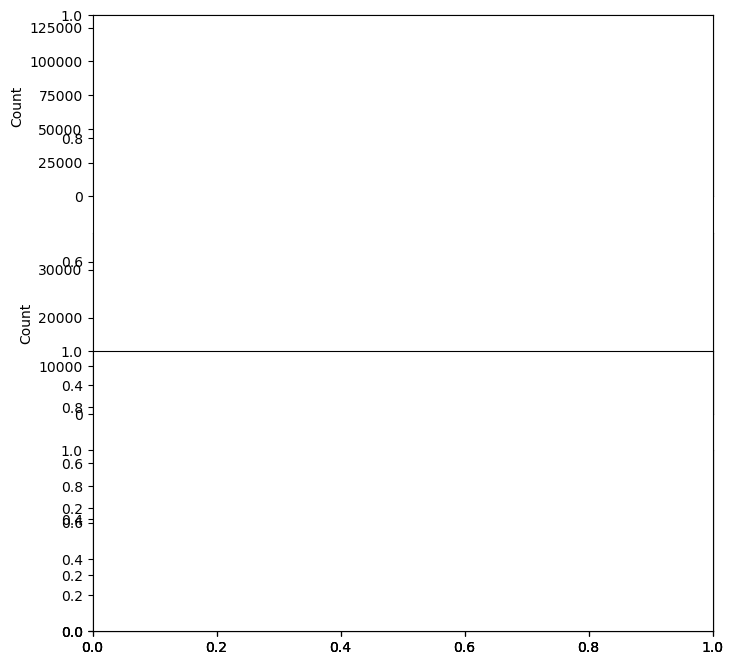

In [105]:
# Create a sample DataFrame


# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,8))

# Plot each column on a separate subplot
ax1 = plt.subplot(1,1,1)
sns.histplot(hotel.Review_Total_Negative_Word_Counts,ax=axes[0])

plt.subplot(2,1,2)
sns.histplot(hotel.Review_Total_Positive_Word_Counts,ax=axes[1])

#plt.subplot(313)
#sns.histplot(hotel.Total_Number_of_Reviews_Reviewer_Has_Given)#(ax=axes[2])

plt.show()


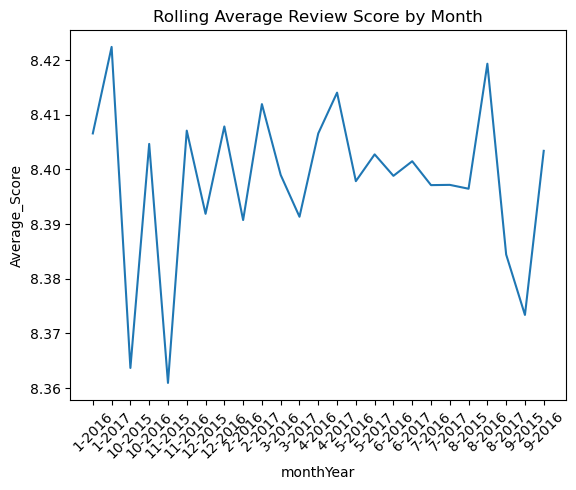

In [70]:
sns.lineplot(AverageReviews.groupby('monthYear')['Average_Score'].mean())
plt.xticks(rotation=45)
plt.title('Rolling Average Review Score by Month')
plt.show()

In [154]:
hotel.groupby(hotel.month.dt.str+hotel.month.dt.str['Average_Score'].count()

KeyError: 'monthYear'

In [ ]:
sns.histplot(hotel.Average_Score)

In [ ]:
plt.hist(hotel.Average_Score)

In [ ]:
plt.figure(figsize=(8,8))
sns.lineplot(x=AverageReviews.Review_Date,y=AverageReviews.Average_Score)
plt.ylim(8.2,8.6)

In [ ]:
AverageReviews.head(1)

In [ ]:
AverageReviews['smoothed_value'] = AverageReviews['Average_Score'].rolling(window=5).mean()
AverageReviews.head(4)

In [ ]:
AverageReviews.info()

In [ ]:
hotel.head(1)

In [ ]:
hotel.info()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncol=1)
plt.subplot(111)
sns.lineplot(x=hotel.Nights_Stayed,y=hotel.Average_Score)

plt.subplot(212)
sns.histplot(hotel.Nights_Stayed)


<Axes: xlabel='Review_Date', ylabel='Average_Score'>

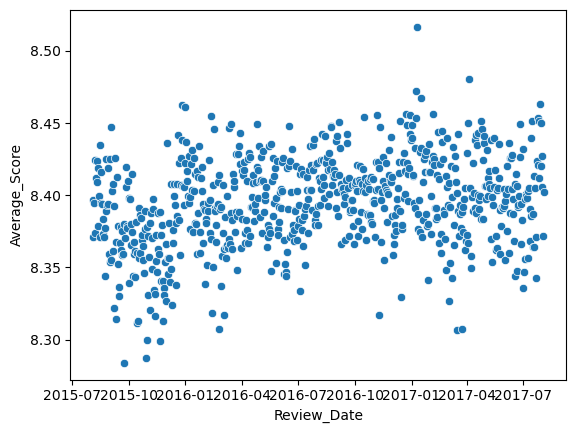

In [70]:
sns.scatterplot(x=AverageReviews.Review_Date,y=AverageReviews.Average_Score)


In [ ]:
hotel.Review_Date.unique()

In [ ]:
AverageReviews.to_frame().info()

In [ ]:
plt.plot(hotel.Review_Date.value(),hotel.groupby('Review_Date').Review_Date.count())

ValueError: x and y must be the same size

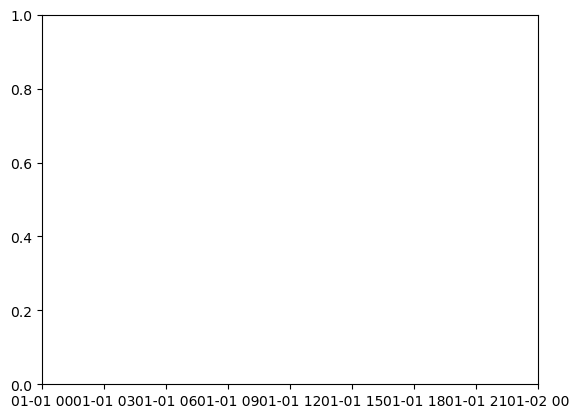

In [128]:
plt.scatter(hotel.Review_Date,hotel.groupby('Review_Date').Average_Score.mean())

In [ ]:
plt.plot(hotel.Review_Date,hotel[hotel.Reviewer_Score==1].count())

In [ ]:
sns.lineplot(x=hotel.Review_Date,y=hotel[hotel.Reviewer_Score==1].count())

In [ ]:
mean(data_dictionary)

In [352]:
hotel.describe()

Reviewer_Score  Nights_Stayed  Additional_Number_of_Scoring  \
count   515199.000000  515199.000000                 515199.000000   
mean         0.570100       2.361750                    498.417604   
std          0.495062       1.646734                    500.673193   
min          0.000000       1.000000                      1.000000   
25%          0.000000       1.000000                    169.000000   
50%          1.000000       2.000000                    342.000000   
75%          1.000000       3.000000                    660.000000   
max          1.000000      31.000000                   2682.000000   

       Average_Score   Leisure_Trip  Days_Since_Review  \
count  515199.000000  515199.000000      515199.000000   
mean        8.397776       0.810070         354.402120   
std         0.547947       0.392246         208.909135   
min         5.200000       0.000000           0.000000   
25%         8.100000       1.000000         175.000000   
50%         8.400000       1.000000         353.000000   
75%         8.800000       1.000000         527.000000   
max         9.800000       1.000000         730.000000   

       Total_Number_of_Reviews  Total_Number_of_Reviews_Reviewer_Has_Given  \
count            515199.000000                               515199.000000   
mean               2744.691424                                    7.164750   
std                2318.112418                                   11.039315   
min                  43.000000                                    1.000000   
25%                1161.000000                                    1.000000   
50%                2134.000000                                    3.000000   
75%                3633.000000                                    8.000000   
max               16670.000000                                  355.000000   

       Review_Total_Negative_Word_Counts  Review_Total_Positive_Word_Counts  \
count                      515199.000000                      515199.000000   
mean                           18.540711                          17.778489   
std                            29.693602                          21.804665   
min                             0.000000                           0.000000   
25%                             2.000000                           5.000000   
50%                             9.000000                          11.000000   
75%                            23.000000                          22.000000   
max                           408.000000                         395.000000   

            Latitude      Longitude            Day          Month  \
count  515199.000000  515199.000000  515199.000000  515199.000000   
mean       49.433012       2.893915      15.680589       6.486043   
std         3.461933       4.669672       8.864227       3.351916   
min        41.328376      -0.369758       1.000000       1.000000   
25%        48.214066      -0.143372       8.000000       4.000000   
50%        51.499981       0.019886      16.000000       7.000000   
75%        51.516288       4.841163      23.000000       9.000000   
max        52.400181      16.429233      31.000000      12.000000   

               Year  Reviewer_Nationality_Australia  \
count  515199.00000                   515199.000000   
mean     2016.12092                        0.042019   
std         0.68751                        0.200632   
min      2015.00000                        0.000000   
25%      2016.00000                        0.000000   
50%      2016.00000                        0.000000   
75%      2017.00000                        0.000000   
max      2017.00000                        1.000000   

       Reviewer_Nationality_Ireland  Reviewer_Nationality_UAE  \
count                 515199.000000             515199.000000   
mean                       0.028754                  0.019853   
std                        0.167114                  0.139494   
min                        0.000000                  0.00000

In [384]:
hotel.Review_Total_Positive_Word_Counts

0          11
1         105
2          21
3          26
4           8
         ... 
515733      2
515734     11
515735      0
515736     25
515737      6
Name: Review_Total_Positive_Word_Counts, Length: 515199, dtype: int64

In [389]:
# positive word count per negative review
print('Number of Words in Negative Reviews: ',hotel.Review_Total_Negative_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))
print('Number of Words in Positive Reviews: ',hotel.Review_Total_Positive_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))
# negative word count per negative review

Number of Words in Negative Reviews:  43.127973126726985
Number of Words in Positive Reviews:  31.184856067957032


In [380]:
(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count())/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count())

1.3261228802080511

In [398]:
hotel.Review_Date

0        2017-08-03
1        2017-08-03
2        2017-07-31
3        2017-07-31
4        2017-07-24
            ...    
515733   2015-08-30
515734   2015-08-22
515735   2015-08-19
515736   2015-08-17
515737   2015-08-09
Name: Review_Date, Length: 515199, dtype: datetime64[ns]

In [400]:
hotel.shape

(515199, 30)

In [401]:
hotel[hotel.Reviewer_Score==]

Reviewer_Score  Nights_Stayed  \
7                    1              2   
10                   1              2   
13                   1              1   
14                   1              5   
15                   1              1   
...                ...            ...   
515720               1              1   
515723               1              1   
515729               1              2   
515732               1              2   
515736               1              3   

                                          Positive_Review  \
7        Good location Set in a lovely park friendly s...   
10       Rooms were stunningly decorated and really sp...   
13       This hotel is being renovated with great care...   
14       It was very good very historic building that ...   
15       This hotel is awesome I took it sincirely bec...   
...                                                   ...   
515720         Location if you are visiting for a concert   
515723   Second to none location if you re off to Stad...   
515729   The breakfast was excelent lots of fress frui...   
515732   helpful staff allowed me to check in early as...   
515736   The rooms are enormous and really comfortable...   

                                          Negative_Review  \
7        Apart from the price for the brekfast Everyth...   
10                                     Nothing all great    
13                                            No Negative   
14       The staff in the restaurant could of been mor...   
15                                            No Negative   
...                                                   ...   
515720                                Expensive breakfast   
515723                                        No Negative   
515729                                        No Negative   
515732                                        No Negative   
515736                                        No Negative   

        Additional_Number_of_Scoring  Average_Score  Leisure_Trip  \
7                                194            7.7             1   
10                               194            7.7             1   
13                               194            7.7             0   
14                               194            7.7             1   
15                               194            7.7             1   
...                              ...            ...           ...   
515720                           168            8.1             1   
515723                           168            8.1             1   
515729                           168            8.1             1   
515732                           168            8.1             1   
515736                           168            8.1             1   

        Days_Since_Review  Total_Number_of_Reviews  \
7                      17                     1403   
10                     27                     1403   
13                     30                     1403   
14                     30                     1403   
15                     31                     1403   
...                   ...                      ...   
515720                603                     2823   
515723                627                     2823   
515729                677                     2823   
515732                697                     2823   
515736                717                     2823   

        Total_Number_of_Reviews_Reviewer_Has_Given  \
7                                                1   
10                                               2   
13                                               6   
14                                               1   
15                                              26   
...                                            ...   
515720                                           1   
515723                                           1   
515729                                           7   
515732                         

Reviewer_Score
1    293715
0    221484
Name: count, dtype: int64


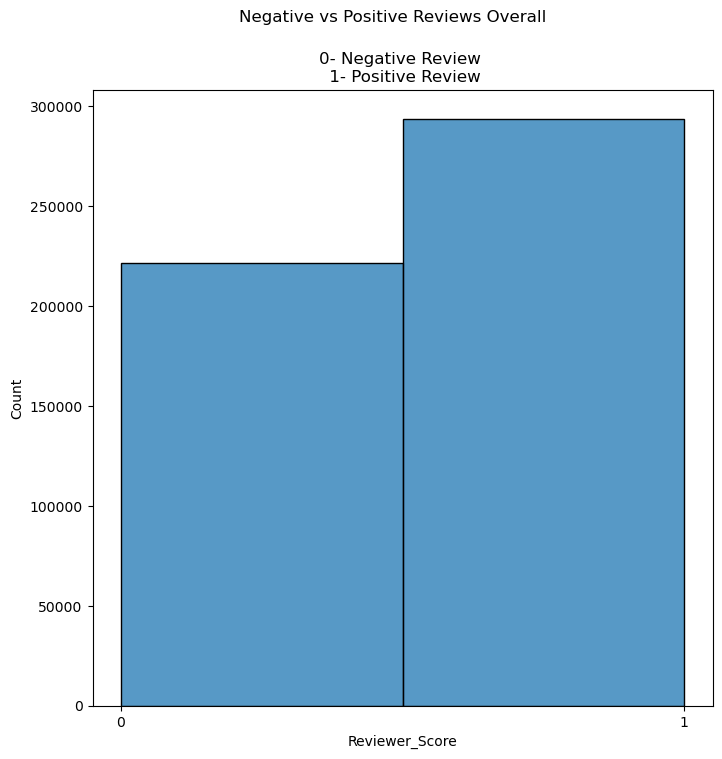

In [372]:
print(hotel.Reviewer_Score.value_counts())
plt.figure(figsize=(8,8))
sns.histplot(hotel.Reviewer_Score, bins=2)
plt.xticks(np.arange(0, 1.1, step=1))
plt.suptitle('Negative vs Positive Reviews Overall')
plt.title('0- Negative Review \n 1- Positive Review')
plt.show()

Pretty simple here - generally positive reviews.

Text(0.5, 0, 'Average Score')

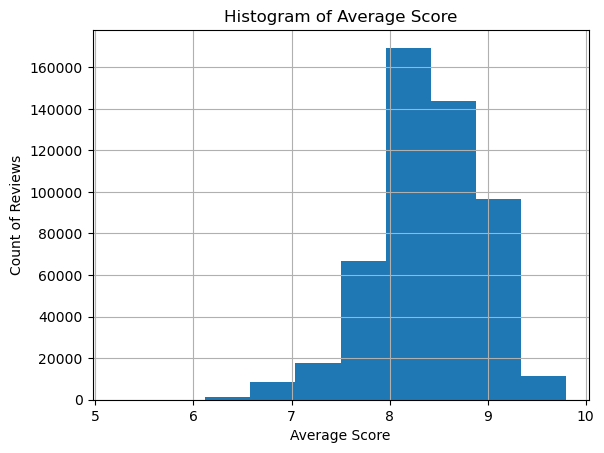

In [145]:
plt.figure()
hotel.Average_Score.hist()
plt.title("Histogram of Average Score")
plt.ylabel('Count of Reviews')
plt.xlabel('Average Score')

In [349]:
hotel.head(3)

Reviewer_Score  Nights_Stayed  \
0               0              6   
1               0              4   
2               0              3   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   

                                     Negative_Review  \
0   I am so angry that i made this post available...   
1                                        No Negative   
2   Rooms are nice but for elderly a bit difficul...   

   Additional_Number_of_Scoring  Average_Score  Leisure_Trip  \
0                           194            7.7             1   
1                           194            7.7             1   
2                           194            7.7             1   

   Days_Since_Review  Total_Number_of_Reviews  \
0                  0                     1403   
1                  0                     1403   
2                  3                     1403   

   Total_Number_of_Reviews_Reviewer_Has_Given  \
0                                           7   
1                                           7   
2                                           9   

   Review_Total_Negative_Word_Counts  Review_Total_Positive_Word_Counts  \
0                                397                                 11   
1                                  0                                105   
2                                 42                                 21   

    Latitude  Longitude  Day  Month  Year  Reviewer_Nationality_Australia  \
0  52.360576   4.915968    3      8  2017                               0   
1  52.360576   4.915968    3      8  2017                               0   
2  52.360576   4.915968   31      7  2017                               1   

   Reviewer_Nationality_Ireland  Reviewer_Nationality_UAE  \
0                             0                         0   
1                             1                         0   
2                             0                         0   

   Reviewer_Nationality_UK  Reviewer_Nationality_USA  \
0                        0                         0   
1                        0                         0   
2                        0                         0   

   Reviewer_Nationality_Other  Hotel_Address_Amsterdam  \
0                           1                        1   
1                           0                        1   
2                           0                        1   

   Hotel_Address_Barcelona  Hotel_Address_London  Hotel_Address_Milan  \
0                        0                     0                    0   
1                        0                     0                    0   
2                        0                     0                    0   

   Hotel_Address_Paris  Hotel_Address_Vienna  
0                    0                     0  
1                    0                     0  
2                    0                     0

In [ ]:
plt.figure(figsize=(8,8))
sns.hist()

In [ ]:
plt.scatter(Nights_Stayed,)

<Axes: >

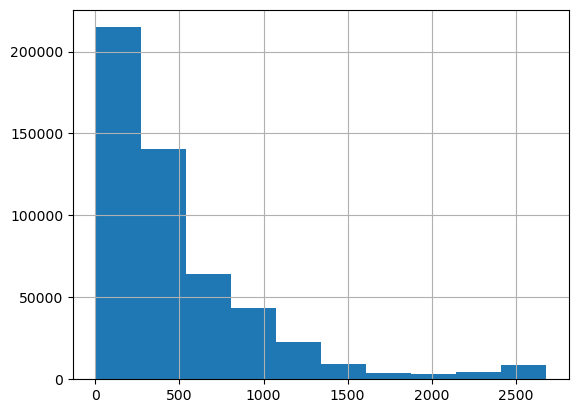

In [348]:
plt.subplot(111)
hotel.Additional_Number_of_Scoring.hist()

18.539450263505888
9561499


<Axes: >

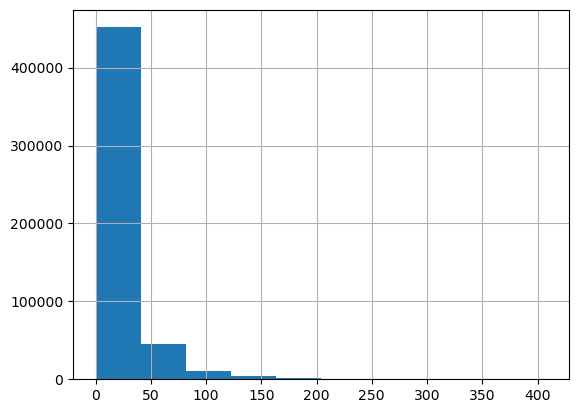

In [90]:
print(hotel.Review_Total_Negative_Word_Counts.mean())
print(hotel.Review_Total_Negative_Word_Counts.sum())
hotel.Review_Total_Negative_Word_Counts.hist()

17.77645820164502
9167995


<Axes: >

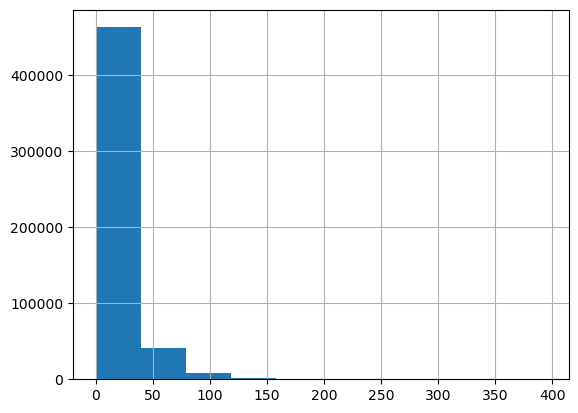

In [91]:
print(hotel.Review_Total_Positive_Word_Counts.mean())
print(hotel.Review_Total_Positive_Word_Counts.sum())
hotel.Review_Total_Positive_Word_Counts.hist()

In [92]:
hotel.describe()

Unnamed: 0  Additional_Number_of_Scoring  \
count  515738.000000                 515738.000000   
mean   257868.500000                    498.081836   
std    148880.880902                    500.538467   
min         0.000000                      1.000000   
25%    128934.250000                    169.000000   
50%    257868.500000                    341.000000   
75%    386802.750000                    660.000000   
max    515737.000000                   2682.000000   

       Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
count                      515738.000000            515738.000000   
mean                           18.539450              2743.743944   
std                            29.690831              2317.464868   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%                            23.000000              3613.000000   
max                           408.000000             16670.000000   

       Review_Total_Positive_Word_Counts  \
count                      515738.000000   
mean                           17.776458   
std                            21.804185   
min                             0.000000   
25%                             5.000000   
50%                            11.000000   
75%                            22.000000   
max                           395.000000   

       Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
count                               515738.000000   515738.000000   
mean                                     7.166001        0.570006   
std                                     11.040228        0.495075   
min                                      1.000000        0.000000   
25%                                      1.000000        0.000000   
50%                                      3.000000        1.000000   
75%                                      8.000000        1.000000   
max                                    355.000000        1.000000   

       Days_Since_Review       Latitude      Longitude  ...  \
count      515738.000000  515738.000000  515738.000000  ...   
mean          354.441932      49.432419       2.893479  ...   
std           208.928124       3.460237       4.667477  ...   
min             0.000000      41.328376      -0.369758  ...   
25%           175.000000      48.214066      -0.143372  ...   
50%           353.000000      51.499981       0.019886  ...   
75%           527.000000      51.516288       4.841163  ...   
max           730.000000      52.400181      16.429233  ...   

       Reviewer_Nationality_USA  Reviewer_Nationality_Other  \
count             515738.000000               515738.000000   
mean                   0.068711                    0.365121   
std                    0.252963                    0.481465   
min                    0.000000                    0.000000   
25%                    0.000000                    0.000000   
50%                    0.000000                    0.000000   
75%                    0.000000                    1.000000   
max                    1.000000                    1.000000   

       Hotel_Address_Amsterdam  Hotel_Address_Barcelona  Hotel_Address_London  \
count            515738.000000            515738.000000         515738.000000   
mean                  0.110936                 0.116627              0.508594   
std                   0.314053                 0.320976              0.499927   
min                   0.000000                 0.000000              0.000000   
25%                   0.000000                 0.000000              0.000000   
50%                   0.000000                 0.000000              1.000000   
75%                   0.000000                 0.000000              1.000000   
max                   1.000000                 1.000000              1.000000   

       Hotel_Add

In [93]:
min(hotel.Average_Score)
max(hotel.Average_Score)

'NaN'

In [96]:
sns.histplot(hotel.Average_Score)
plt.xlim(4,11)plt.show()


SyntaxError: invalid syntax (811814420.py, line 2)

In [ ]:
for x in hotel.columns:
    hotel[x].hist()

In [97]:
hotel.shape

(515738, 30)

In [59]:
pd.set_option("display.max_columns", None)

In [100]:
hotel.head(2)

Unnamed: 0  Additional_Number_of_Scoring Average_Score  \
0           0                           194           NaN   
1           1                           194           NaN   

                                     Negative_Review  \
0   I am so angry that i made this post available...   
1                                        No Negative   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7               0   
1                                           7               0   

   Days_Since_Review   Latitude  Longitude  Day  Month  Year  \
0                  0  52.360576   4.915968    3      8  2017   
1                  0  52.360576   4.915968    3      8  2017   

   Reviewer_Nationality_Australia  Reviewer_Nationality_Ireland  \
0                               0                             0   
1                               0                             1   

   Reviewer_Nationality_UAE  Reviewer_Nationality_UK  \
0                         0                        0   
1                         0                        0   

   Reviewer_Nationality_USA  Reviewer_Nationality_Other  \
0                         0                           1   
1                         0                           0   

   Hotel_Address_Amsterdam  Hotel_Address_Barcelona  Hotel_Address_London  \
0                        1                        0                     0   
1                        1                        0                     0   

   Hotel_Address_Milan  Hotel_Address_Paris  Hotel_Address_Vienna  \
0                    0                    0                     0   
1                    0                    0                     0   

   Leisure_Trip  Nights_Stayed  
0             1              6  
1             1              4

## Question 2 Scrap
### Part 1

In [155]:
PositiveReviews=hotel[hotel.Reviewer_Score==1]

In [156]:
NegativeReviews=hotel[hotel.Reviewer_Score==0]

In [142]:
len(hotel.Latitude.unique())

1489

In [132]:
hotel.head(5)
# It seems like scoring and total_num reviews are consistent and duplictive
# There are columns whose data don't contribute to an overall analysis.
# Additional Number of Scoring and Total_Number_of_Reviews:
#######   These are repetitive unless aggregated at column value

Reviewer_Score  Nights_Stayed  \
0               0              6   
1               0              4   
2               0              3   
3               0              3   
4               0              2   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

                                     Negative_Review  \
0   I am so angry that i made this post available...   
1                                        No Negative   
2   Rooms are nice but for elderly a bit difficul...   
3   My room was dirty and I was afraid to walk ba...   
4   You When I booked with your company on line y...   

   Additional_Number_of_Scoring  Average_Score  Leisure_Trip  \
0                           194            7.7             1   
1                           194            7.7             1   
2                           194            7.7             1   
3                           194            7.7             1   
4                           194            7.7             1   

   Days_Since_Review  Total_Number_of_Reviews  \
0                  0                     1403   
1                  0                     1403   
2                  3                     1403   
3                  3                     1403   
4                 10                     1403   

   Total_Number_of_Reviews_Reviewer_Has_Given  ...  Reviewer_Nationality_UK  \
0                                           7  ...                        0   
1                                           7  ...                        0   
2                                           9  ...                        0   
3                                           1  ...                        1   
4                                           3  ...                        0   

   Reviewer_Nationality_USA  Reviewer_Nationality_Other  \
0                         0                           1   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           1   

   Hotel_Address_Amsterdam  Hotel_Address_Barcelona  Hotel_Address_London  \
0                        1                        0                     0   
1                        1                        0                     0   
2                        1                        0                     0   
3                        1                        0                     0   
4                        1                        0                     0   

   Hotel_Address_Milan  Hotel_Address_Paris  Hotel_Address_Vienna  Review_Date  
0                    0                    0                     0   2017-08-03  
1                    0                    0                     0   2017-08-03  
2                    0                    0                     0   2017-07-31  
3                    0                    0                     0   2017-07-31  
4                    0                    0                     0   2017-07-24  

[5 rows x 30 columns]

In [134]:
hotel.groupby(['Additional_Number_of_Scoring','Total_Number_of_Reviews','Average_Score']).Nights_Stayed.mean()

Additional_Number_of_Scoring  Total_Number_of_Reviews  Average_Score
1                             49                       8.9              3.230769
4                             66                       8.0              2.666667
5                             67                       8.9              3.071429
                              97                       8.8              2.760000
6                             69                       7.9              2.500000
                                                                          ...   
1831                          7105                     8.1              2.091977
1936                          7491                     8.7              1.697073
2288                          9568                     8.1              1.959352
2623                          12158                    8.7              2.224754
2682                          9086                     7.1              1.643141
Name: Nights_Stayed, Length: 1494, dtype

In [135]:
hotel['Positive_Review',

0          Only the park outside of the hotel was beauti...
1          No real complaints the hotel was great great ...
2          Location was good and staff were ok It is cut...
3          Great location in nice surroundings the bar a...
4           Amazing location and building Romantic setting 
                                ...                        
515733                                             location
515734        Breakfast was ok and we got earlier check in 
515735                                          No Positive
515736     The rooms are enormous and really comfortable...
515737                                 staff was very kind 
Name: Positive_Review, Length: 515199, dtype: object

In [131]:
#Get subset of data

hotel_sub=hotel.sample(frac=0.2)


In [ ]:
###Logistic Regression

# Target = Reviewer Score
# Splitting the data
X=
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fitting the linear model
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)